In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
%matplotlib inline
import h5py 
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [0]:
with h5py.File("/content/gdrive/My Drive/Sign.h5","r") as hdf:
    data1=hdf.get('X')
    data2=hdf.get('Y')
    X=np.array(data1)
    Y=np.array(data2)

In [0]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.20,random_state=42)

In [6]:
print(X_train.shape)

(1440, 128, 128, 3)


In [7]:
print(X_test.shape)

(360, 128, 128, 3)


In [0]:
X_train = X_train/255.
X_test = X_test/255.

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [0]:
Y_train = convert_to_one_hot(Y_train, 6).T
Y_test = convert_to_one_hot(Y_test, 6).T

In [11]:
print(Y_train.shape)

(1440, 6)


In [12]:
print(Y_test.shape)

(360, 6)


In [0]:
def identity_block(X, f, filters, stage, block):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut]) 
    X = Activation('relu')(X)
        
    return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    F1, F2, F3 = filters
    
    X_shortcut = X

    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    X = Conv2D(F2, (f, f), strides = (1,1), name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0), padding = 'same')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(F3, (1, 1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
        
    return X

In [0]:
def ResNet50(input_shape = (128, 128, 3), classes = 6):
    
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [128,128,512], stage=2, block='b')
    X = identity_block(X, 3, [128,128,512], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=3, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=3, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage=4, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=4, block='c')
    X = identity_block(X, 3, [512,512,2048], stage=4, block='d')
    X = identity_block(X, 3, [512,512,2048], stage=4, block='e')
    X = identity_block(X, 3, [512,512,2048], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [1024,1024,4096], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [1024,1024,4096], stage=5, block='b')
    X = identity_block(X, 3, [1024,1024,4096], stage=5, block='c')

    X = AveragePooling2D((2, 2), name = 'avg_pool')(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [18]:
model = ResNet50(input_shape = (128, 128, 3), classes = 6)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.fit(X_train, Y_train, epochs = 20, batch_size = 32)


Epoch 1/20
1440/1440 [==============================] - 28s 19ms/step - loss: 4.9180 - accuracy: 0.4243
Epoch 2/20
1440/1440 [==============================] - 19s 13ms/step - loss: 3.1026 - accuracy: 0.6340
Epoch 3/20
1440/1440 [==============================] - 20s 14ms/step - loss: 1.7707 - accuracy: 0.7285
Epoch 4/20
1440/1440 [==============================] - 19s 13ms/step - loss: 0.1611 - accuracy: 0.9549
Epoch 5/20
1440/1440 [==============================] - 19s 13ms/step - loss: 0.1056 - accuracy: 0.9736
Epoch 6/20
1440/1440 [==============================] - 19s 13ms/step - loss: 0.1505 - accuracy: 0.9722
Epoch 7/20
1440/1440 [==============================] - 19s 13ms/step - loss: 0.0422 - accuracy: 0.9896
Epoch 8/20
1440/1440 [==============================] - 19s 13ms/step - loss: 0.0121 - accuracy: 0.9965
Epoch 9/20
1440/1440 [==============================] - 19s 13ms/step - loss: 0.0233 - accuracy: 0.9944
Epoch 10/20
1440/1440 [==============================] - 19s 13

In [21]:
preds = model.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

360/360 [==============================] - 3s 7ms/step
Loss = 1.3541940143490339
Test Accuracy = 0.9777777791023254


Input image shape: (1, 128, 128, 3)


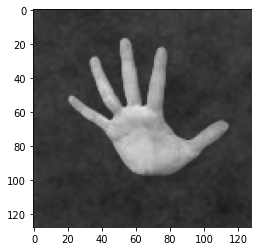

In [38]:
img_path = '/content/gdrive/My Drive/signtestdata/five1.png'
img = image.load_img(img_path, target_size=(128, 128))
plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x/255.0
print('Input image shape:', x.shape)


In [39]:
print("class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = ")
pred=model.predict(x)
print(np.squeeze(pred))

class prediction vector [p(0), p(1), p(2), p(3), p(4), p(5)] = 
[1.6558019e-27 7.7391043e-18 1.3042309e-15 3.5955870e-18 1.1821036e-11
 1.0000000e+00]


In [40]:
p=np.argmax(pred)
print("Pridicted digit is : "+str(p))

Pridicted digit is : 5


In [44]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
model.save("/content/gdrive/My Drive/sign_cnn.h5")